# Dự đoán thời gian gắn bó của nhân viên mớimới
Mục tiêu: Dự báo nhân viên có rời công ty sớm hay không. Ở đây em sẽ dựa vào các đặc trưng liên quan như mức độ hài lòng, số giờ làm việc trung bình/tháng, số năm gắn bó, số dự án đã làm, lương, thăng chức,... để đánh giá xem nhân viên đó có nghỉ việc sớm hay ở lại.

# Đọc và hiển thị dữ liệu

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("HR_comma_sep (2).csv")
df.head()
#df.time_spend_company.value_counts()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


# Hiển thị tổng quan dữ liệu

In [12]:
print("Số dòng:", df.shape[0])
print("Số cột:", df.shape[1])
df.info()
df.describe()
df["left"].value_counts()


Số dòng: 14999
Số cột: 10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


left
0    11428
1     3571
Name: count, dtype: int64

left là cột mục tiêu (0: ở lại, 1: nghỉ việc), tại cột left, ta đếm được có 11428 giá trị 1 tương ứng là nghỉ việc, 3571 giá trị ở lại




##Xử lý dữ liệu

In [13]:
df = pd.get_dummies(df, columns=["Department", "salary"], drop_first=True)
df.head()


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,False,False,False,False,False,False,True,False,False,True,False
1,0.80,0.86,5,262,6,0,1,0,False,False,False,False,False,False,True,False,False,False,True
2,0.11,0.88,7,272,4,0,1,0,False,False,False,False,False,False,True,False,False,False,True
3,0.72,0.87,5,223,5,0,1,0,False,False,False,False,False,False,True,False,False,True,False
4,0.37,0.52,2,159,3,0,1,0,False,False,False,False,False,False,True,False,False,True,False


Chuyển cột categorical (chuỗi ký tự) như Department và salary thành dạng số để mô hình học máy có thể xử lý được.

- pd.get_dummies(...): Tạo biến giả (dummy variables) cho các cột chứa giá trị dạng text.

- columns=["Department", "salary"]: Chỉ định các cột cần biến đổi.

- drop_first=True: Loại bỏ 1 cột đầu tiên để tránh đa cộng tuyến (multicollinearity) trong các mô hình tuyến tính như Logistic Regression.



## Trực quan hoá dữ liệu

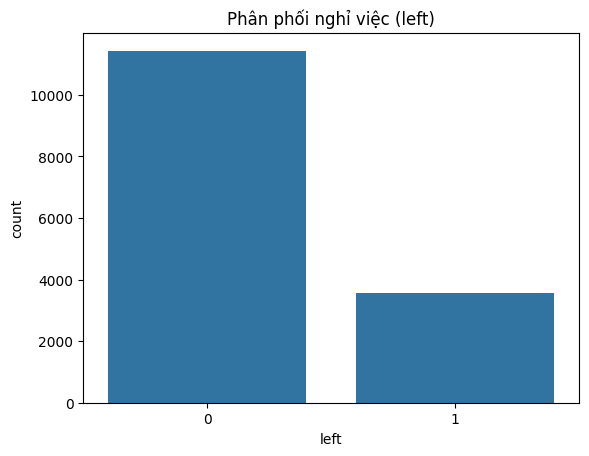

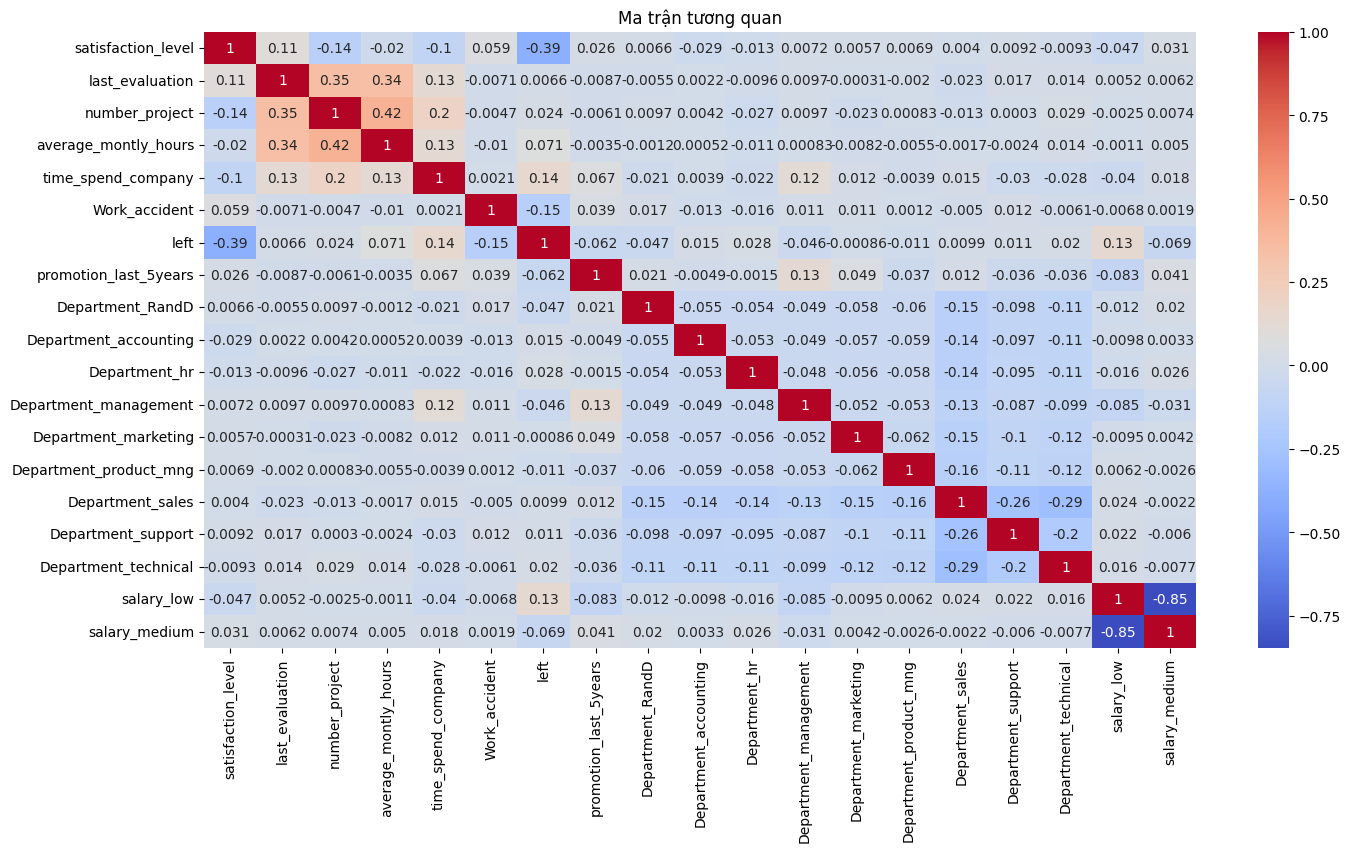

In [14]:
# Phân phối nhân viên nghỉ việc
sns.countplot(x="left", data=df)
plt.title("Phân phối nghỉ việc (left)")

# Heatmap tương quan
plt.figure(figsize=(16,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Ma trận tương quan")
plt.show()


**Hiển thị số lượng nhân viên nghỉ việc (left = 1) và ở lại (left = 0) bằng biểu đồ cột.**

Cột left có 2 giá trị:

- 0: nhân viên ở lại

- 1: nhân viên nghỉ việc

**Heatmap tương quan:**

- df.corr() tính hệ số tương quan Pearson giữa các cột số.

- annot=True: hiện giá trị số lên ô.

- cmap="coolwarm": màu xanh – đỏ cho độ âm/dương của tương quan.

- figsize=(16,8): chỉnh kích thước hình cho rõ hơn.

**Phân tích heatmap:**
Dựa trên heatmap tương quan giữa các đặc trưng và biến mục tiêu left (nghỉ việc), em sẽ rút ra một số điểm nổi bật:

- Mức độ hài lòng (satisfaction_level) có tương quan âm mạnh nhất với việc nghỉ việc (-0.39). Điều này cho thấy nhân viên càng không hài lòng thì khả năng nghỉ việc càng cao.

- Mức lương thấp (salary_low) có tương quan dương khá rõ với việc nghỉ việc (+0.41). Nhân viên có thu nhập thấp dễ rời bỏ công ty hơn.

- Ngược lại, mức lương trung bình (salary_medium) có tương quan âm (-0.15), cho thấy họ ít có xu hướng nghỉ việc hơn so với nhóm lương thấp.

- Thời gian làm việc tại công ty (time_spend_company) có tương quan dương nhẹ (+0.14), ngụ ý rằng nhân viên làm lâu năm có thể bắt đầu rời bỏ công ty do sự mệt mỏi hoặc thiếu cơ hội phát triển.

- Một số yếu tố như tai nạn lao động (Work_accident) hay được thăng chức trong 5 năm (promotion_last_5years) cũng cho thấy mối liên hệ âm với nghỉ việc, tức những nhân viên này có xu hướng gắn bó hơn.

- Kết quả này giúp xác định những yếu tố quan trọng ảnh hưởng đến hành vi nghỉ việc của nhân viên và là cơ sở để xây dựng mô hình dự đoán phù hợp.

##Tiền xử lý để huấn luyện

In [15]:
from sklearn.model_selection import train_test_split

X = df.drop("left", axis=1)
y = df["left"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**X = df.drop("left", axis=1):**

Tạo biến X chứa tất cả các cột trong DataFrame df ngoại trừ cột "left". Cột này là biến mục tiêu mà mô hình sẽ dự đoán.
axis=1 cho biết rằng chúng ta muốn xóa một cột chứ không phải một hàng.

**y = df["left"]:**

Tạo biến y chứa dữ liệu từ cột "left". Đây là biến mục tiêu mà mô hình cần dự đoán.

**X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42):**

sử dụng hàm train_test_split để chia dữ liệu thành 4 tập:
- X_train: Dữ liệu huấn luyện cho các biến đầu vào.
- X_test: Dữ liệu kiểm tra cho các biến đầu vào.
- y_train: Dữ liệu huấn luyện cho biến mục tiêu.
- y_test: Dữ liệu kiểm tra cho biến mục tiêu.
- test_size=0.2 có nghĩa là 20% dữ liệu sẽ được sử dụng để kiểm tra, còn lại 80% để huấn luyện.
- random_state=42 được sử dụng để đảm bảo rằng việc chia dữ liệu là giống nhau mỗi khi chạy mã. Điều này giúp cho kết quả có thể tái tạo được.

##Huấn luyện mô hình Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

model_log = LogisticRegression(max_iter=1000)
model_log.fit(X_train, y_train)
y_pred_log = model_log.predict(X_test)

print("Mô hình Logistic Regression")
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))
print("Accuracy:", accuracy_score(y_test, y_pred_log))


Mô hình Logistic Regression
[[2118  176]
 [ 474  232]]
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      2294
           1       0.57      0.33      0.42       706

    accuracy                           0.78      3000
   macro avg       0.69      0.63      0.64      3000
weighted avg       0.76      0.78      0.76      3000

Accuracy: 0.7833333333333333


**Tạo và huấn luyện mô hình:**

- model_log = LogisticRegression(max_iter=1000): Tạo một đối tượng của lớp LogisticRegression. max_iter=1000 chỉ định số lần lặp tối đa để bộ giải hội tụ, đảm bảo quá trình huấn luyện mô hình hoàn tất.
- model_log.fit(X_train, y_train): Huấn luyện mô hình hồi quy logistic bằng dữ liệu huấn luyện (X_train cho các đặc trưng và y_train cho biến mục tiêu).

**Dự đoán:**
- model_log.predict(X_test): Sử dụng mô hình đã được huấn luyện để dự đoán biến mục tiêu cho dữ liệu kiểm tra (X_test). Kết quả dự đoán được lưu trữ trong y_pred_log.

**Sau khi huấn luyện ta thu được các kết quả như sau:**

1.   Ma trận nhầm lẫn

- TP = 228: Số lượng nhân viên nghỉ việc (lớp 1) được dự đoán đúng.(True Positive)
- TN = 2117: Số lượng nhân viên ở lại (lớp 0) được dự đoán đúng.(True Negative)
- FP = 177: Số lượng nhân viên ở lại (lớp 0) bị dự đoán sai là nghỉ việc (lớp 1).(False positive)
- FN = 478: Số lượng nhân viên nghỉ việc (lớp 1) bị dự đoán sai là ở lại (lớp 0).(False Negative)

2.   classification_report

**Precision (Độ chính xác):**
- Lớp 0 (ở lại): 0.82 - Trong số những nhân viên được dự đoán là ở lại, 82% thực sự ở lại.
- Lớp 1 (nghỉ việc): 0.56 - Trong số những nhân viên được dự đoán là nghỉ việc, chỉ 56% thực sự nghỉ việc.

**Recall (Độ nhạy):**
- Lớp 0 (ở lại): 0.92 - Trong số những nhân viên thực sự ở lại, 92% được dự đoán đúng.
- Lớp 1 (nghỉ việc): 0.32 - Trong số những nhân viên thực sự nghỉ việc, chỉ 32% được dự đoán đúng.

**F1-score:**
- Lớp 0 (ở lại): 0.87 - Trung bình điều hòa giữa precision và recall cho lớp 0.
- Lớp 1 (nghỉ việc): 0.41 - Trung bình điều hòa giữa precision và recall cho lớp 1.

**Support:**
- Lớp 0 (ở lại): 2294 - Số lượng nhân viên thực sự ở lại trong tập kiểm tra.
- Lớp 1 (nghỉ việc): 706 - Số lượng nhân viên thực sự nghỉ việc trong tập kiểm tra.

**Accuracy (Độ chính xác tổng thể):** 0.78 - Tỷ lệ dự đoán đúng trên tổng số dự đoán là 78%.

**Macro average:** Trung bình cộng của precision, recall và F1-score cho tất cả các lớp (không tính đến trọng số của mỗi lớp).

**Weighted average:** Trung bình cộng của precision, recall và F1-score cho tất cả các lớp, được tính trọng số dựa trên support của mỗi lớp.

3. Độ chính xác tổng thể của mô hình

Độ chính xác tổng thể của mô hình là 78.17%, gần bằng với accuracy trong classification_report(0.78).

##Huấn luyện mô hình SVM

In [17]:
from sklearn.svm import SVC

model_svm = SVC(kernel='linear')
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)

print("Mô hình SVM")
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))


Mô hình SVM
[[2139  155]
 [ 541  165]]
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      2294
           1       0.52      0.23      0.32       706

    accuracy                           0.77      3000
   macro avg       0.66      0.58      0.59      3000
weighted avg       0.73      0.77      0.73      3000

Accuracy: 0.768


**Khởi tạo và huẩn luyện mô hình:**
- model_svm = SVC(kernel='linear'): Tạo một đối tượng của lớp SVC với kernel='linear'. Điều này có nghĩa là chúng ta sẽ sử dụng một hạt nhân tuyến tính để tạo siêu phẳng phân tách dữ liệu.
- model_svm.fit(X_train, y_train): Huấn luyện mô hình SVM bằng dữ liệu huấn luyện (X_train cho các đặc trưng và y_train cho biến mục tiêu). Quá trình huấn luyện sẽ tìm ra siêu phẳng tối ưu để phân loại dữ liệu.

**Dự đoán:**
- model_svm.predict(X_test): Sử dụng mô hình SVM đã được huấn luyện để dự đoán biến mục tiêu cho dữ liệu kiểm tra (X_test). Kết quả dự đoán được lưu trữ trong y_pred_svm.

**Sau khi huấn luyện em thu được các kết quả như sau:**

1.   Ma trận nhầm lẫn

- TP = 165: Số lượng nhân viên nghỉ việc (lớp 1) được dự đoán đúng.(True Positive)
- TN = 2139: Số lượng nhân viên ở lại (lớp 0) được dự đoán đúng.(True Negative)
- FP = 155: Số lượng nhân viên ở lại (lớp 0) bị dự đoán sai là nghỉ việc (lớp 1).(False positive)
- FN = 541: Số lượng nhân viên nghỉ việc (lớp 1) bị dự đoán sai là ở lại (lớp 0).(False Negative)

2.   classification_report

**Precision (Độ chính xác):**
- Lớp 0 (ở lại): 0.80 - Trong số những nhân viên được dự đoán là ở lại, 80% thực sự ở lại.
- Lớp 1 (nghỉ việc): 0.52 - Trong số những nhân viên được dự đoán là nghỉ việc, chỉ 52% thực sự nghỉ việc.

**Recall (Độ nhạy):**
- Lớp 0 (ở lại): 0.93 - Trong số những nhân viên thực sự ở lại, 93% được dự đoán đúng.
- Lớp 1 (nghỉ việc): 0.23 - Trong số những nhân viên thực sự nghỉ việc, chỉ 23% được dự đoán đúng.

**F1-score:**
- Lớp 0 (ở lại): 0.86 - Trung bình điều hòa giữa precision và recall cho lớp 0.
- Lớp 1 (nghỉ việc): 0.32 - Trung bình điều hòa giữa precision và recall cho lớp 1.

**Support:**
- Lớp 0 (ở lại): 2294 - Số lượng nhân viên thực sự ở lại trong tập kiểm tra.
- Lớp 1 (nghỉ việc): 706 - Số lượng nhân viên thực sự nghỉ việc trong tập kiểm tra.

**Accuracy (Độ chính xác tổng thể):** 0.77 - Tỷ lệ dự đoán đúng trên tổng số dự đoán là 77%.

**Macro average:** Trung bình cộng của precision, recall và F1-score cho tất cả các lớp (không tính đến trọng số của mỗi lớp).

**Weighted average:** Trung bình cộng của precision, recall và F1-score cho tất cả các lớp, được tính trọng số dựa trên support của mỗi lớp.

3. Độ chính xác tổng thể của mô hình

Độ chính xác tổng thể của mô hình là 76.8%, gần bằng với accuracy trong classification_report(0.77).

##So sánh giữa 2 mô hình

**Độ chính xác (Accuracy):** Mô hình 2 (Logistic Regression) có độ chính xác tổng thể cao hơn một chút (78.16%) so với mô hình 1 (SVM - 76.8%). Điều này cho thấy mô hình 2 dự đoán đúng nhiều trường hợp hơn trên toàn bộ tập dữ liệu.

**Precision:**

- Đối với lớp 0 (ở lại): Mô hình 2 có precision cao hơn một chút (0.82 so với 0.80), có nghĩa là nó ít dự đoán sai nhân viên ở lại thành nghỉ việc hơn.
- Đối với lớp 1 (nghỉ việc): Mô hình 2 cũng có precision cao hơn (0.56 so với 0.52), cho thấy nó ít dự đoán sai nhân viên nghỉ việc thành ở lại hơn.

**Recall:**

- Đối với lớp 0 (ở lại): Recall của hai mô hình gần bằng nhau (0.93 so với 0.92), cho thấy cả hai đều dự đoán tốt những nhân viên thực sự ở lại.
- Đối với lớp 1 (nghỉ việc): Recall của cả hai mô hình đều thấp, nhưng mô hình 2 có recall cao hơn một chút so với mô hình 1 (0.32 so với 0.23). Điều này cho thấy mô hình 2 có khả năng dự đoán đúng những nhân viên thực sự nghỉ việc tốt hơn một chút, dù không đáng kể.

**F1-score:**

- F1-score là trung bình điều hòa giữa precision và recall, cho thấy hiệu suất tổng thể của mô hình cho từng lớp.
- Đối với lớp 0 (ở lại): F1-score của mô hình 2 cao hơn một chút (0.87 so với 0.86).
- Đối với lớp 1 (nghỉ việc): F1-score của mô hình 2 cũng cao hơn (0.41 so với 0.32).

**Kết luận:**

- Nhìn chung, mô hình 2 (Logistic Regression) có hiệu suất tốt hơn một chút so với mô hình 1 (SVM) trong bài toán này. Mô hình 2 có độ chính xác tổng thể cao hơn, precision và F1-score tốt hơn cho cả hai lớp.

##Lưu mô hình

In [18]:
import joblib
joblib.dump(model_log, "logistic_model.pkl")
joblib.dump(model_svm, "svm_model.pkl")


['svm_model.pkl']

##Xây dựng giao diện thử nghiệm bằng gradio

In [19]:
!pip install gradio


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\STMTLS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [20]:
import gradio as gr
import joblib
import pandas as pd

model = joblib.load("svm_model.pkl")

def predict_retention(satisfaction, evaluation, projects, hours, time, accident, promotion, department, salary):
    # Tạo input dataframe từ người dùng
    df = pd.DataFrame([[satisfaction, evaluation, projects, hours, time, accident, promotion, department, salary]],
                      columns=['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours',
                               'time_spend_company', 'Work_accident', 'promotion_last_5years', 'Department', 'salary'])

    # Tiền xử lý
    df = pd.get_dummies(df)

    missing_cols = set(model.feature_names_in_) - set(df.columns)
    for col in missing_cols:
        df[col] = 0
    df = df[model.feature_names_in_]

    pred = model.predict(df)[0]
    return "Nghỉ việc" if pred == 1 else "Ở lại"

iface = gr.Interface(
    fn=predict_retention,
    inputs=[
        gr.Slider(0, 1, step=0.01, label="Mức độ hài lòng"),
        gr.Slider(0, 1, step=0.01, label="Đánh giá cuối cùng"),
        gr.Slider(1, 7, step=1, label="Số dự án"),
        gr.Slider(80, 320, step=1, label="Số giờ trung bình / tháng"),
        gr.Slider(1, 10, step=1, label="Số năm làm việc"),
        gr.Radio([0, 1], label="Tai nạn lao động"),
        gr.Radio([0, 1], label="Thăng chức 5 năm qua"),
        gr.Dropdown(['sales', 'accounting', 'hr', 'technical', 'support', 'management', 'IT', 'product_mng', 'marketing', 'RandD'], label="Phòng ban"),
        gr.Dropdown(['low', 'medium', 'high'], label="Lương")
    ],
    outputs="text",
    title="Dự đoán Nghỉ việc"
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Tại giao diện thử nghiệm, có thể thử với 2 mô hình em đã lưu và đóng gói ở trên. Ở đây em sẽ thử nghiệm với mô hình SVM với các thuộc tính như sau:

Các giá trị đầu vào thử nghiệm:

- Mức độ hài lòng: 0.15
→ Mức hài lòng của nhân viên rất thấp (gần sát mức 0).

- Đánh giá cuối cùng: 0.2
→ Nhân viên được đánh giá hiệu suất thấp trong kỳ đánh giá gần nhất.

- Số dự án: 6
→ Mức độ tham gia dự án khá cao, có thể gây áp lực.

- Số giờ trung bình / tháng: 243 giờ/tháng
→ Rất cao so với trung bình (khoảng 160–180 giờ/tháng), cho thấy nhân viên có thể đang bị quá tải.

- Số năm làm việc: 8 năm
→ Là nhân viên lâu năm.

- Tai nạn lao động: 0
→ Không có tai nạn lao động.

- Thăng chức 5 năm qua: 0
→ Không có sự thăng tiến trong suốt 5 năm qua.

- Phòng ban: IT
→ Nhân viên thuộc bộ phận Công nghệ thông tin.

- Lương: medium
→ Mức lương trung bình.

Kết quả dự đoán: “Nghỉ việc”

Với những yếu tố đầu vào như:

- Hài lòng thấp,

- Đánh giá thấp,

- Làm nhiều giờ,

- Không thăng tiến,

- Làm lâu năm nhưng không có thay đổi tích cực,